In [1]:
import os
import numpy as np
import tensorflow.keras.preprocessing.image as img_preproc
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
from models import get_model
import json
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

input_dir = "/data/datasets/MoNuSAC_images_and_annotations/"
target_dir = "/data/datasets/MoNuSAC_bin_masks/"
img_size = (160, 160)
num_classes = 5
batch_size = 8

with open('/data/datasets/processed_dataset.json', 'r') as file:
    dataset = json.load(file)

input_img_paths = dataset['images']    
target_img_paths = dataset['masks']
    
print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)
    
assert len(input_img_paths)>0,"input_dir is empty"
assert len(input_img_paths)>0,"target_dir is empty"

Number of samples: 3245
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_00.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_00.npy
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_01.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_01.npy
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_02.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_02.npy
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_03.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_03.npy
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_04.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_04.npy
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_10.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_10.npy
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_11.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_11.npy
TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_12.tif | TCGA-MP-A4T7-01Z-00-DX1/TCGA-MP-A4T7-01Z-00-DX1_3_mask_12.npy
TCGA-MP-

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

2022-12-27 00:41:16.457627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 00:41:16.477946: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1896520000 Hz
2022-12-27 00:41:16.478575: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3210250 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-12-27 00:41:16.478585: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
import random
from dataset import Challenge

# Split our img paths into a training and a validation set
val_samples = 50
#random.Random(1337).shuffle(input_img_paths)
#random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Challenge(
    batch_size, img_size, input_dir, target_dir, train_input_img_paths, train_target_img_paths, shuffle=False, augment=False
)
val_gen = Challenge(
    batch_size, img_size, input_dir, target_dir, val_input_img_paths, val_target_img_paths, shuffle=False, augment=False
)

In [5]:
#train_input_img_paths

In [6]:
#train_target_img_paths

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

metrics = ['accuracy']

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=metrics)

In [8]:
callbacks = [
    ModelCheckpoint("monusac-challenge_segmentation_baseline.h5", save_best_only=True),
    EarlyStopping(min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
]

# Train the model for 50 epochs, in reality it will stop earlier because of the EarlyStopping
epochs = 50
history = model.fit(train_gen, 
                    epochs=epochs, 
                    validation_data=val_gen, 
                    callbacks=callbacks)

Epoch 1/50
399/399 [==============================] - 187s 468ms/step - loss: 2.9417 - accuracy: 0.9964 - val_loss: 0.6365 - val_accuracy: 1.0000
Epoch 2/50
399/399 [==============================] - 203s 510ms/step - loss: 2.9281 - accuracy: 1.0000 - val_loss: 0.6365 - val_accuracy: 1.0000
Epoch 3/50
399/399 [==============================] - 213s 534ms/step - loss: 2.9281 - accuracy: 1.0000 - val_loss: 0.6365 - val_accuracy: 1.0000
Epoch 4/50
399/399 [==============================] - 210s 526ms/step - loss: 2.9281 - accuracy: 1.0000 - val_loss: 0.6365 - val_accuracy: 1.0000
Epoch 5/50
399/399 [==============================] - 210s 525ms/step - loss: 2.9281 - accuracy: 1.0000 - val_loss: 0.6365 - val_accuracy: 1.0000
Epoch 6/50
399/399 [==============================] - 208s 521ms/step - loss: 2.9281 - accuracy: 1.0000 - val_loss: 0.6365 - val_accuracy: 1.0000
Epoch 7/50
399/399 [==============================] - 208s 521ms/step - loss: 2.9281 - accuracy: 1.0000 - val_loss: 0.6365 -

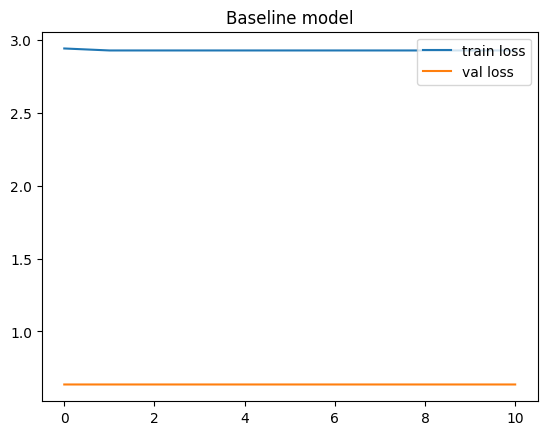

In [9]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc="upper right")
plt.title("Baseline model")
plt.show()

# Model evaluation - validation set

In [10]:
from segmentation_metrics import calculate_metrics

val_gen = ISICChallenge(1, 
                        img_size, 
                        val_input_img_paths, 
                        val_target_img_paths, 
                        shuffle=False, 
                        augment=False)

val_preds = model.predict(val_gen)

NameError: name 'ISICChallenge' is not defined

In [ ]:
y = np.zeros((len(val_input_img_paths),) + img_size + (1,), dtype="uint8")
for i, mask_path in enumerate(val_target_img_paths):
    mask = np.array(load_img(mask_path, target_size=img_size, color_mode="grayscale"))
    mask[mask>0] = 1
    mask = np.expand_dims(mask, 2)
    y[i] = mask

In [ ]:
y = np.squeeze(y)
pr_masks = np.argmax(val_preds, axis=-1)
y.shape, pr_masks.shape

In [ ]:
assert y.shape==pr_masks.shape, "number of test samples doesn't match predictions"

In [ ]:
calculate_metrics(y, val_preds)

In [ ]:
max_img = 5
pr_masks = np.argmax(val_preds, axis=-1)
    
for img_path, mask_path, pr_mask in zip(val_input_img_paths[:max_img], 
                                        val_target_img_paths[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(img_path, target_size=img_size)
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# Model evaluation - Test set

In [ ]:
input_dir = "images/test/"
target_dir = "annotations/test/"

test_input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(test_input_img_paths))

In [ ]:
test_gen = ISICChallenge(
    1, img_size, test_input_img_paths, test_target_img_paths, shuffle=False, augment=False
)

In [ ]:
test_preds = model.predict(test_gen)

### load all masks as used in training to calculate metrics

In [ ]:
y = np.zeros((len(test_input_img_paths),) + img_size + (1,), dtype="uint8")
for i, mask_path in enumerate(test_target_img_paths):
    mask = np.array(load_img(mask_path, target_size=img_size, color_mode="grayscale"))
    mask[mask>0] = 1
    mask = np.expand_dims(mask, 2)
    y[i] = mask

In [ ]:
y = np.squeeze(y)
pr_masks = np.argmax(test_preds, axis=-1)
y.shape, pr_masks.shape

In [ ]:
assert y.shape==pr_masks.shape, "number of test samples doesn't match predictions"

In [ ]:
calculate_metrics(y, test_preds)

## Visualization

In [ ]:
max_img = 3
    
for img_path, mask_path, pr_mask in zip(test_input_img_paths[:max_img], 
                                        test_target_img_paths[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(img_path, target_size=img_size)
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()